# Import necessary libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## pre-processing and analysis

In [44]:
data = pd.read_csv('./data/diabetes_prediction_dataset.csv')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


in this case, we don't have any null values, so we don't need to drop any rows.

now we will analyze the objetive variable, in this case, 'diabetes'

In [46]:
data['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

the objetive variable is not balanced, so we will need to balance it later.

now we will analyze the categorical variables in this dataset we have 2 categorical variables, so we will need to encode them later.

In [47]:
data['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [48]:
data['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

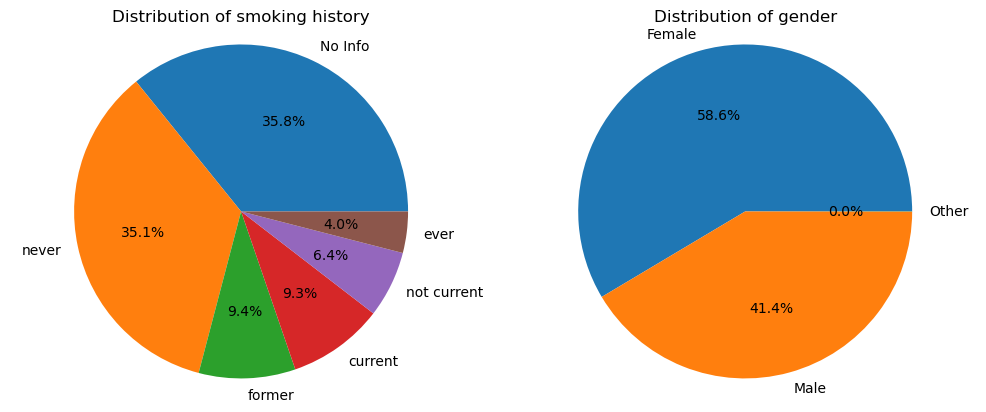

In [49]:
# Create a pie chart for the 'smoking_history' variable
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.pie(data['smoking_history'].value_counts(), labels=data['smoking_history'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of smoking history')
plt.axis('equal')

# create a pie chart for the 'gender' variable
plt.subplot(2, 2, 2)
plt.pie(data['gender'].value_counts(), labels=data['gender'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of gender')
plt.axis('equal') 

plt.tight_layout()

now we will analyze the numerical variables in this dataset we have 7 numerical variables, so we will need to scale them later.

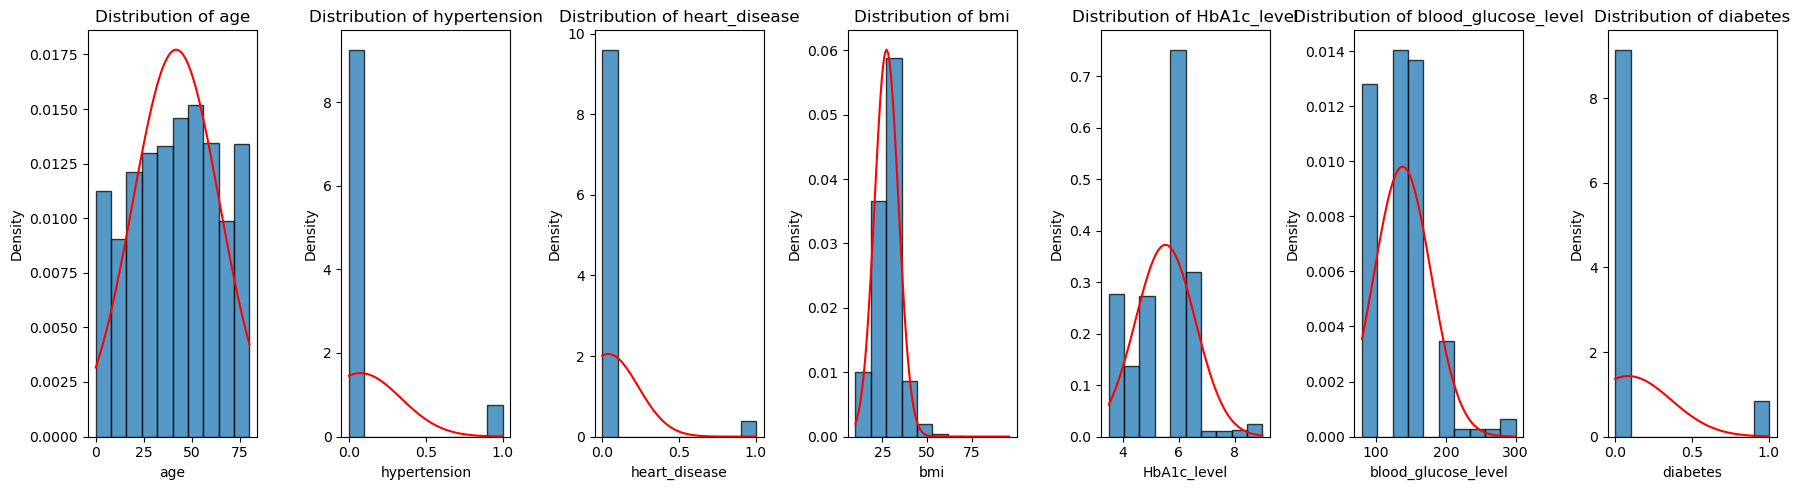

In [50]:

# List of variables to plot
variables = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

# create a figure with 7 subplots arranged in 1 row and 7 columns
plt.figure(figsize=(18, 5))

# create a histogram for each numeric variable
for i, variable in enumerate(variables, start=1):
    plt.subplot(1, 7, i)
    plt.hist(data[variable], bins=10, density=True, alpha=0.75, edgecolor='black')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.title(f'Distribution of {variable}')
    
    # calculate mean and standard deviation
    mu, sigma = data[variable].mean(), data[variable].std()
    
    # create array with the values for normal distribution
    x = np.linspace(data[variable].min(), data[variable].max(), 100)
    y = norm.pdf(x, mu, sigma)
    
    # plot line chart on top of the histogram
    plt.plot(x, y, color='red')
    
plt.tight_layout() 
plt.show()



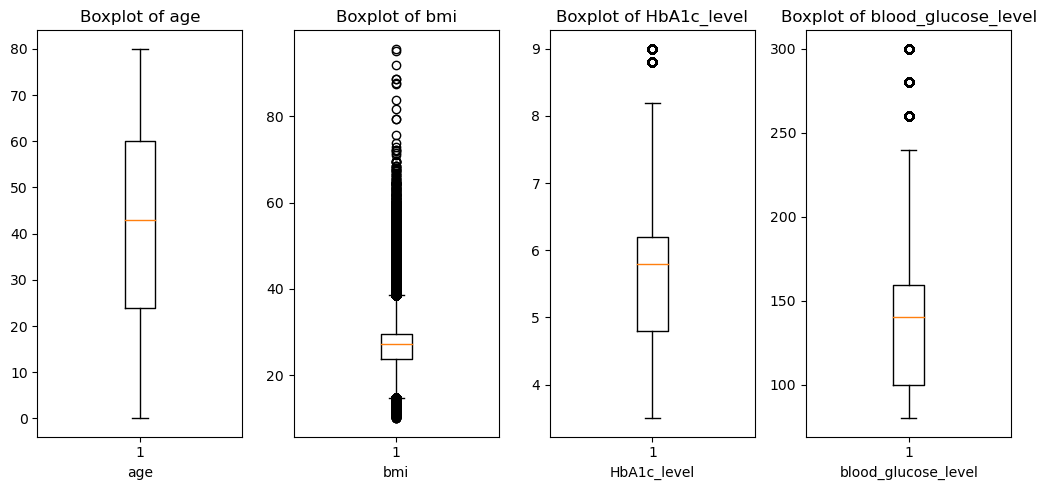

In [51]:
variables_two = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
# Create a figure with subplots
plt.figure(figsize=(18, 5))

# Create boxplots for each variable
for i, variable in enumerate(variables_two, start=1):
    plt.subplot(1, 7, i)
    plt.boxplot(data[variable])
    plt.xlabel(variable)
    plt.title(f'Boxplot of {variable}')

plt.tight_layout()
plt.show()

now we will analyze the correlation between the variables. for this, we will transform the categorical variables into numerical variables.

In [52]:
encoder = OneHotEncoder()

data_encoded = encoder.fit_transform(data[['gender', 'smoking_history']])

# Get categories for each column
gender_categories = encoder.categories_[0]
smoking_categories = encoder.categories_[1]

# Create column names for the new encoded columns
encoded_column_names = list(gender_categories) + list(smoking_categories)

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(data_encoded.toarray(), columns=encoded_column_names)

# Drop the original columns
data.drop(['gender', 'smoking_history'], axis=1, inplace=True)

# Concatenate the original DataFrame with the encoded columns
data = pd.concat([data, encoded_df], axis=1)

In [53]:
# Create a dictionary with the column names to be replaced
replace_dict = {
    'Female': 'Sex-Female',
    'Male': 'Sex-Male',
    'Other': 'Sex-Other',
    'No Info': 'Smoker-No-Info',
    'current': 'Smoker-Current',
    'ever': 'Smoker-Ever',
    'former': 'Smoker-Former',
    'never': 'Smoker-Never',
    'not current': 'Smoker-Not-Current'
}

# replace the column names
data = data.rename(columns=replace_dict)


the variables now are encoded, so we can analyze the correlation between them.

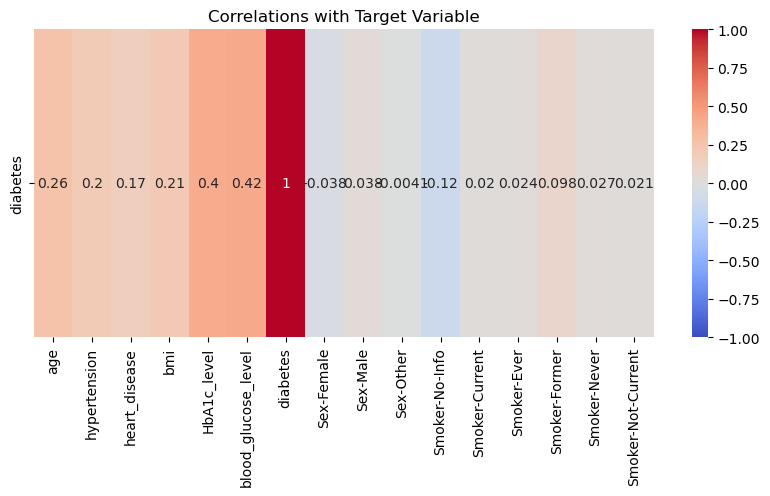

In [54]:
corr_matrix = data.corr()
# Extract the row or column corresponding to the target variable
correlations_with_target = corr_matrix['diabetes']

# Create a new DataFrame containing only the correlation with the target variable
correlations_df = pd.DataFrame(correlations_with_target)

# Plot a heatmap for the correlations with the target variable
plt.figure(figsize=(10, 4))
sns.heatmap(correlations_df.transpose(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlations with Target Variable')
plt.show()

we can see that the variables 'age', 'hypertension', 'heart_disease' and 'bmi' have a relative low correlation with the objetive variable but we will keep them for now. And 'HbA1c_level' and blood_glucose_level' have a relative high correlation with the objetive variable, so we will keep them. the other variables have a low correlation with the objetive variable, so we will drop them.

In [55]:
# Drop the variables with low correlation with the target variable

data.drop(['Sex-Female', 'Sex-Male', 'Sex-Other', 'Smoker-No-Info', 'Smoker-Current', 'Smoker-Ever', 'Smoker-Former', 'Smoker-Never',  'Smoker-Not-Current'], axis=1, inplace=True)

Now we will scale the numerical variables.

In [56]:
# Select the variables to be scaled
variables_to_scaler = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create the scaler
scaler = StandardScaler()

# Estandarize the variables in 'data' and store them in 'data_scaled'
data_scaled = data.copy() 
data_scaled[variables_to_scaler] = scaler.fit_transform(data[variables_to_scaler])



## Modeling with data scaled, not scaled and not balanced

Accuracy: 0.9588333333333333
Confusion Matrix:
[[27203   250]
 [  985  1562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27453
           1       0.86      0.61      0.72      2547

    accuracy                           0.96     30000
   macro avg       0.91      0.80      0.85     30000
weighted avg       0.96      0.96      0.96     30000



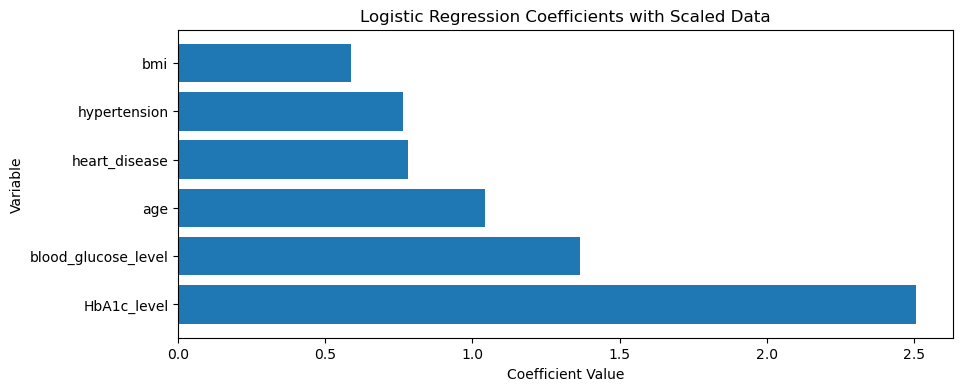

In [57]:
# model building and evaluation with data scaled


# Select the variables for the model
X = data_scaled.drop('diabetes', axis=1)
y = data_scaled['diabetes']

# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create a DataFrame with the coefficients
coefs = pd.DataFrame(model.coef_, columns=X.columns)
coefs = coefs.transpose()
coefs.columns = ['coef']
coefs['abs'] = coefs['coef'].abs()
coefs = coefs.sort_values(by='abs', ascending=False)

# Plot a bar chart with the coefficients
plt.figure(figsize=(10, 4))
plt.barh(coefs.index, coefs['coef'])
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Logistic Regression Coefficients with Scaled Data')
plt.show()

Accuracy: 0.9588333333333333
Confusion Matrix:
[[27203   250]
 [  985  1562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27453
           1       0.86      0.61      0.72      2547

    accuracy                           0.96     30000
   macro avg       0.91      0.80      0.85     30000
weighted avg       0.96      0.96      0.96     30000



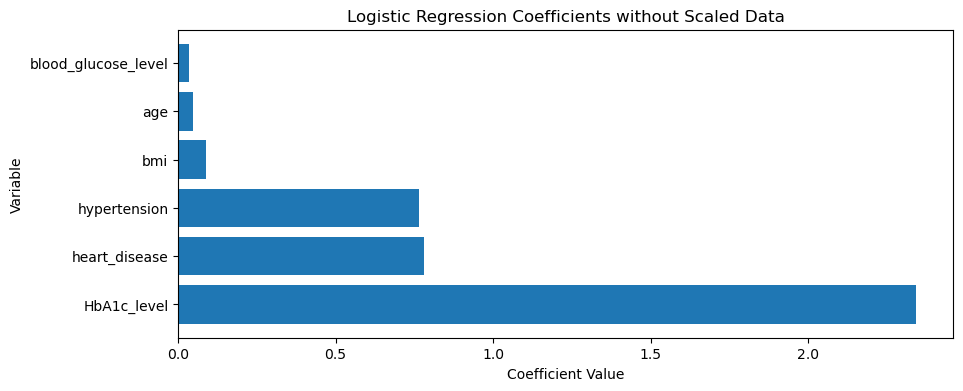

In [58]:
# model building and evaluation without data scaled
X_normal = data.drop('diabetes', axis=1)
y_normal = data['diabetes']

# Split the data into train and test sets
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)

# Create the model
model_normal = LogisticRegression()

# Train the model
model_normal.fit(X_train_normal, y_train_normal)

# Make predictions
y_pred_normal = model_normal.predict(X_test_normal)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_normal, y_pred_normal))
print('Confusion Matrix:')
print(confusion_matrix(y_test_normal, y_pred_normal))
print('Classification Report:')
print(classification_report(y_test_normal, y_pred_normal))

# Create a DataFrame with the coefficients
coefs_normal = pd.DataFrame(model_normal.coef_, columns=X_normal.columns)
coefs_normal = coefs_normal.transpose()
coefs_normal.columns = ['coef']
coefs_normal['abs'] = coefs_normal['coef'].abs()
coefs_normal = coefs_normal.sort_values(by='abs', ascending=False)

# Plot a bar chart with the coefficients
plt.figure(figsize=(10, 4))
plt.barh(coefs_normal.index, coefs_normal['coef'])
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Logistic Regression Coefficients without Scaled Data')
plt.show()


When used data without scaling, the coefficients values are different from the values when used scaled data. So, we will use scaled data.
In Diabetes the level of HbA1c and Blood glucose are important to diagnose the disease. The unbalanced data cause a problem in the model, the confusion matrix show that the model is predicting more False Negatives than False Positives.

## ## Modeling with data scaled, not scaled and balanced

Model with data scaling and balanced class weight

Accuracy: 0.8863333333333333
Confusion Matrix:
[[24364  3089]
 [  321  2226]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     27453
           1       0.42      0.87      0.57      2547

    accuracy                           0.89     30000
   macro avg       0.70      0.88      0.75     30000
weighted avg       0.94      0.89      0.90     30000



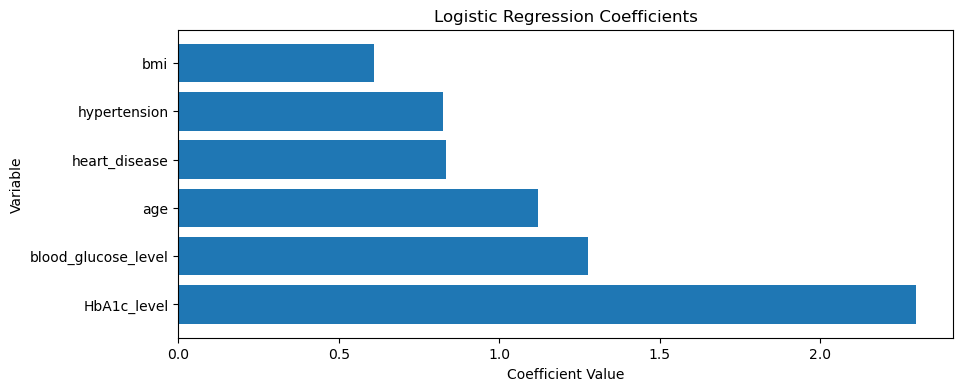

In [59]:
# Create the model
model_balanced = LogisticRegression(class_weight='balanced')

# Train the model
model_balanced.fit(X_train, y_train)

# Make predictions
y_pred_balanced = model_balanced.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred_balanced))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_balanced))
print('Classification Report:')
print(classification_report(y_test, y_pred_balanced))

# Create a DataFrame with the coefficients
coefs_balanced = pd.DataFrame(model_balanced.coef_, columns=X.columns)
coefs_balanced = coefs_balanced.transpose()
coefs_balanced.columns = ['coef']
coefs_balanced['abs'] = coefs_balanced['coef'].abs()
coefs_balanced = coefs_balanced.sort_values(by='abs', ascending=False)

# Plot a bar chart with the coefficients
plt.figure(figsize=(10, 4))
plt.barh(coefs_balanced.index, coefs_balanced['coef'])
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Logistic Regression Coefficients with Balanced Data and Scaled Data')
plt.show()


The atributte 'class_weight' is used to balance the data. But the model is predicting more False positives than False Negatives. In health, it is better to predict more False Positives than False Negatives, because it is better to predict that a person has diabetes and she/he does not have, than predict that a person does not have diabetes and she/he has.


Now we will use resampling to balance the data. and compare the results in data scaled and not scaled.

Resample the data without scaling

In [60]:
# Separating samples for each class
data_majority = data[data['diabetes'] == 0]
data_minority = data[data['diabetes'] == 1]

# Undersample the majority class to have the same number of samples as the minority class
data_majority_downsampled = resample(data_majority, replace=False, n_samples=len(data_minority), random_state=42)

# Combine the downsampled class and the minority class
data_balanced = pd.concat([data_majority_downsampled, data_minority])

# Checking the class balance
print(data_balanced['diabetes'].value_counts())


diabetes
0    8500
1    8500
Name: count, dtype: int64


Model without data scaling but resample

Accuracy: 0.8813725490196078
Confusion Matrix:
[[2259  309]
 [ 296 2236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2568
           1       0.88      0.88      0.88      2532

    accuracy                           0.88      5100
   macro avg       0.88      0.88      0.88      5100
weighted avg       0.88      0.88      0.88      5100



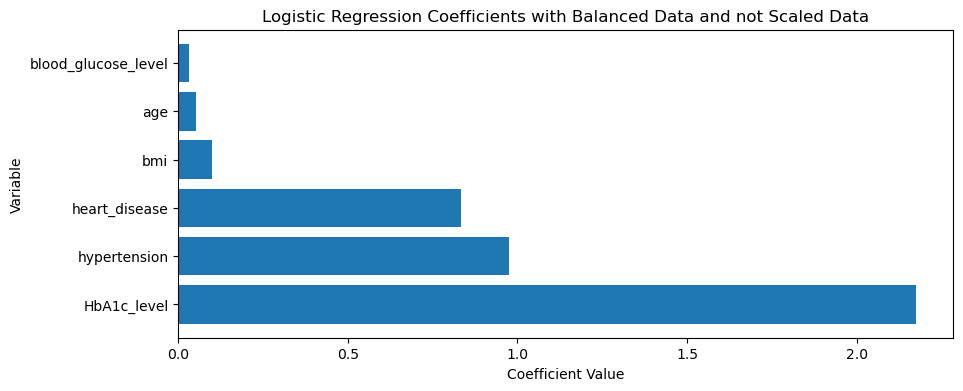

In [64]:
# Select the variables for the model
X_balanced = data_balanced.drop('diabetes', axis=1)
y_balanced = data_balanced['diabetes']

# Split the data into train and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Create the model
model_balanced = LogisticRegression(max_iter=1000)

# Train the model
model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_balanced = model_balanced.predict(X_test_balanced)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_balanced, y_pred_balanced))
print('Confusion Matrix:')
print(confusion_matrix(y_test_balanced, y_pred_balanced))
print('Classification Report:')
print(classification_report(y_test_balanced, y_pred_balanced))

# Create a DataFrame with the coefficients
coefs_balanced = pd.DataFrame(model_balanced.coef_, columns=X_balanced.columns)
coefs_balanced = coefs_balanced.transpose()
coefs_balanced.columns = ['coef']
coefs_balanced['abs'] = coefs_balanced['coef'].abs()
coefs_balanced = coefs_balanced.sort_values(by='abs', ascending=False)

# Plot a bar chart with the coefficients
plt.figure(figsize=(10, 4))
plt.barh(coefs_balanced.index, coefs_balanced['coef'])
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Logistic Regression Coefficients with Balanced Data and not Scaled Data')
plt.show()



Resample the data with scaling

In [62]:
# Separating samples for each class
data_majority_scaled = data_scaled[data_scaled['diabetes'] == 0]
data_minority_scaled = data_scaled[data_scaled['diabetes'] == 1]

# Undersample the majority class to have the same number of samples as the minority class
data_majority_downsampled_scaled = resample(data_majority_scaled, replace=False, n_samples=len(data_minority_scaled), random_state=42)

# Combine the downsampled class and the minority class
data_balanced_scaled = pd.concat([data_majority_downsampled_scaled, data_minority_scaled])

# Checking the class balance
print(data_balanced_scaled['diabetes'].value_counts())

diabetes
0    8500
1    8500
Name: count, dtype: int64


Model with data scaling and resample

Accuracy: 0.8813725490196078
Confusion Matrix:
[[2259  309]
 [ 296 2236]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2568
           1       0.88      0.88      0.88      2532

    accuracy                           0.88      5100
   macro avg       0.88      0.88      0.88      5100
weighted avg       0.88      0.88      0.88      5100



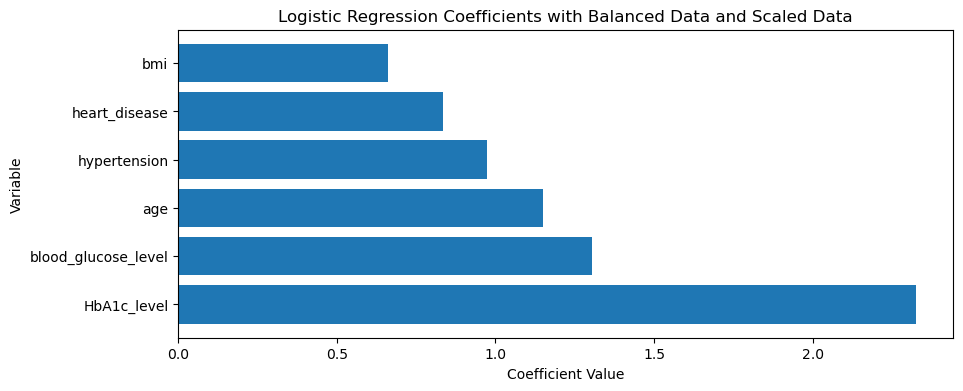

In [65]:
# Select the variables for the model
X_balanced_scaled = data_balanced_scaled.drop('diabetes', axis=1)
y_balanced_scaled = data_balanced_scaled['diabetes']

# Split the data into train and test sets
X_train_balanced_scaled, X_test_balanced_scaled, y_train_balanced_scaled, y_test_balanced_scaled = train_test_split(X_balanced_scaled, y_balanced_scaled, test_size=0.3, random_state=42)

# Create the model
model_balanced_scaled = LogisticRegression()

# Train the model
model_balanced_scaled.fit(X_train_balanced_scaled, y_train_balanced_scaled)

# Make predictions
y_pred_balanced_scaled = model_balanced_scaled.predict(X_test_balanced_scaled)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_balanced_scaled, y_pred_balanced_scaled))
print('Confusion Matrix:')
print(confusion_matrix(y_test_balanced_scaled, y_pred_balanced_scaled))
print('Classification Report:')
print(classification_report(y_test_balanced_scaled, y_pred_balanced_scaled))

# Create a DataFrame with the coefficients
coefs_balanced_scaled = pd.DataFrame(model_balanced_scaled.coef_, columns=X_balanced_scaled.columns)
coefs_balanced_scaled = coefs_balanced_scaled.transpose()
coefs_balanced_scaled.columns = ['coef']
coefs_balanced_scaled['abs'] = coefs_balanced_scaled['coef'].abs()
coefs_balanced_scaled = coefs_balanced_scaled.sort_values(by='abs', ascending=False)

# Plot a bar chart with the coefficients
plt.figure(figsize=(10, 4))
plt.barh(coefs_balanced_scaled.index, coefs_balanced_scaled['coef'])
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.title('Logistic Regression Coefficients with Balanced Data and Scaled Data')
plt.show()
